In [1]:
pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 113 kB 4.2 MB/s 
     |████████████████████████████████| 48.3 MB 2.3 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
!pip uninstall opencv-python-headless 

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-d21001fc.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dis

In [3]:
!pip install "opencv-python-headless<4.3" 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.2 MB/s 


In [4]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import torch
import random
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import itertools
import copy

In [5]:
train_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=40),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
       
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)


In [6]:
test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=40),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
!unzip '/content/drive/MyDrive/traffic_sign_classification/final_dataset_v4(32x32).zip' -d '/content/dataset'

In [9]:

train_data_path = '/content/dataset/final_dataset_v1/train' 


train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    


In [10]:
train_image_paths = list(itertools.chain(*train_image_paths))



In [11]:
random.shuffle(train_image_paths)

In [12]:


print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])


train_image_path example:  /content/dataset/final_dataset_v1/train/1/autosave16_10_2012_07_16_46_0__2014__1.jpg
class example:  0


In [13]:
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 
# split train valid from train paths (80,20)

In [ ]:
train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


In [15]:
# create the test_image_paths
test_data_path = '/content/dataset/final_dataset_v1/test'
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

In [16]:
test_image_paths = list(itertools.chain(*test_image_paths))

In [17]:
random.shuffle(test_image_paths)

In [18]:
print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 3725
Valid size: 932
Test size: 1165


In [25]:
#Create index_to_class and class_to_index dictionaries
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [26]:
idx_to_class, class_to_idx

({0: '0', 1: '1'}, {'0': 0, '1': 1})

In [27]:
class Ruts(Dataset):

  def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

  def __len__(self):
        return len(self.image_paths)

  def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

In [28]:
train_dataset = Ruts(train_image_paths,train_transforms)
valid_dataset = Ruts(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = Ruts(test_image_paths,test_transforms)
#test_dataset = Ruts(test_image_paths)

In [29]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)


The shape of tensor for 50th image in train dataset:  torch.Size([3, 32, 32])


In [30]:
print('The label for 50th image in train dataset: ',train_dataset[49][1])


The label for 50th image in train dataset:  0


In [47]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [45]:
train_dataset[0][0].shape


torch.Size([3, 32, 32])

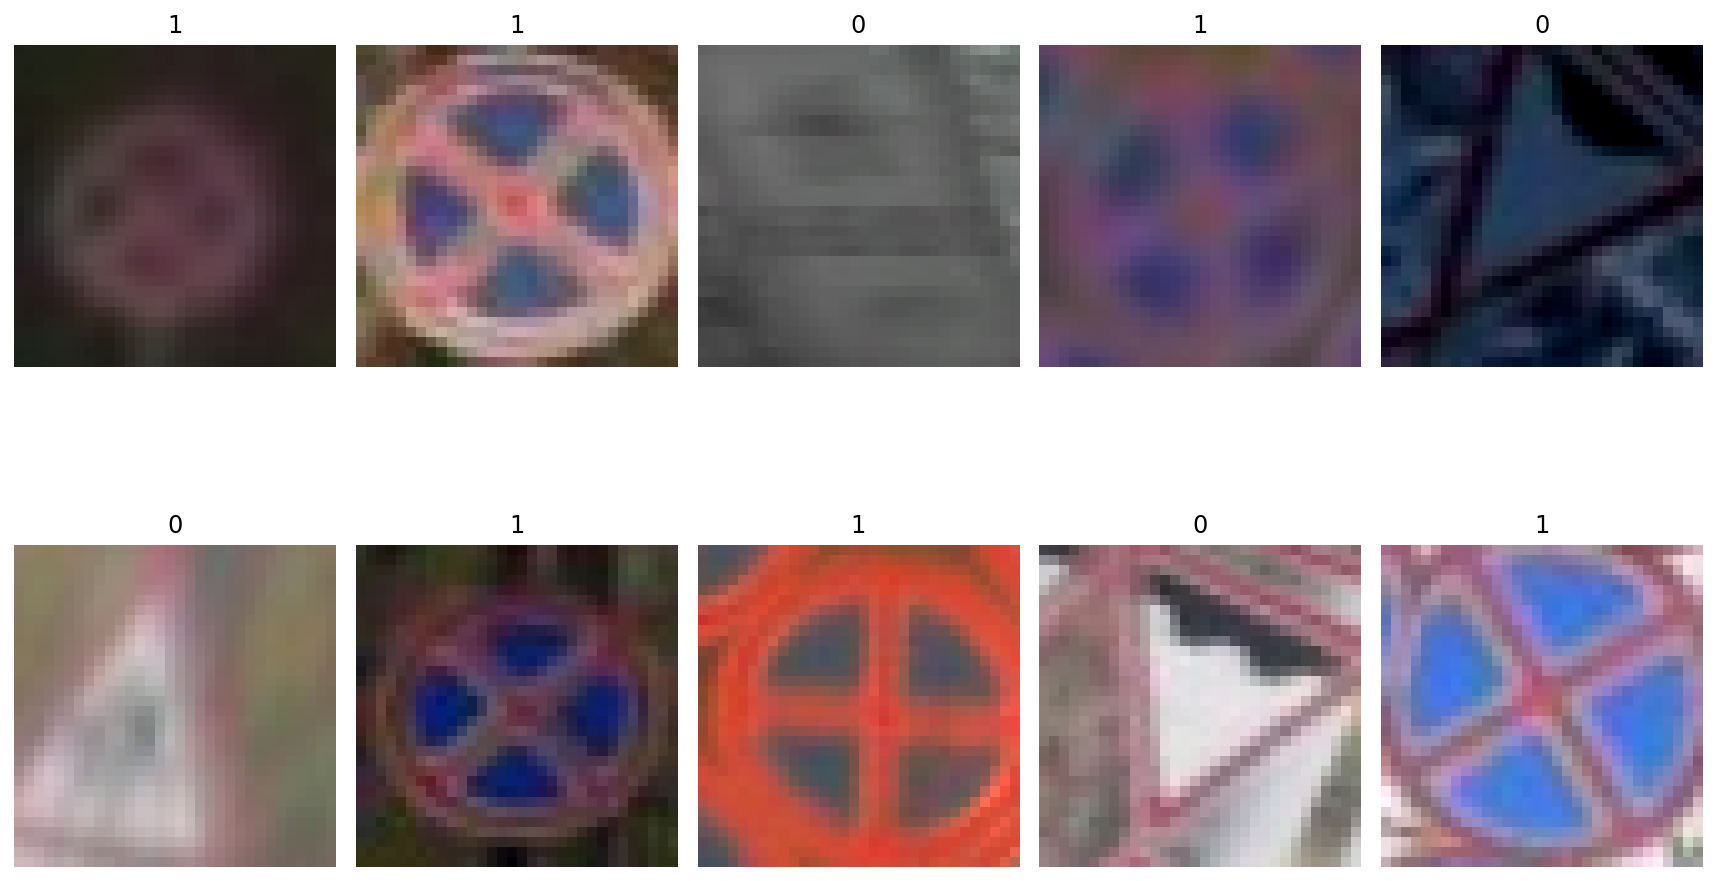

In [30]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [48]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [49]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [51]:
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

In [63]:
train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [52]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

In [53]:
next(iter(train_loader))[1].shape


torch.Size([64])

## Baseline Model

In [54]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
torch.manual_seed(1)


In [56]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 25

In [57]:
model

BaselineNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [58]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [59]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [60]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [61]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [64]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)


[Epoch 1/25] Train loss: 0.692241	Validation loss: 0.691858	 Validation accruacy: 49.249%
[Epoch 2/25] Train loss: 0.688536	Validation loss: 0.682909	 Validation accruacy: 53.433%
[Epoch 3/25] Train loss: 0.683349	Validation loss: 0.669393	 Validation accruacy: 65.129%
[Epoch 4/25] Train loss: 0.675365	Validation loss: 0.648250	 Validation accruacy: 71.674%
[Epoch 5/25] Train loss: 0.661679	Validation loss: 0.618815	 Validation accruacy: 75.000%
[Epoch 6/25] Train loss: 0.645104	Validation loss: 0.600085	 Validation accruacy: 74.142%
[Epoch 7/25] Train loss: 0.630765	Validation loss: 0.578101	 Validation accruacy: 74.356%
[Epoch 8/25] Train loss: 0.611793	Validation loss: 0.562310	 Validation accruacy: 72.532%
[Epoch 9/25] Train loss: 0.599089	Validation loss: 0.536463	 Validation accruacy: 75.644%
[Epoch 10/25] Train loss: 0.582458	Validation loss: 0.507939	 Validation accruacy: 78.433%
[Epoch 11/25] Train loss: 0.566218	Validation loss: 0.470079	 Validation accruacy: 81.760%
[Epoch 1

In [66]:
torch.save(model.state_dict(), '/content/drive/MyDrive/traffic_sign_classification/modelv4.pt')

In [ ]:
next(iter(train_loader))[0].shape

In [65]:
evaluate(model, criterion, test_loader)

Test loss: 0.112489	Test accruacy: 95.365%
